In [160]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import PIL.Image
import random
import concurrent.futures

import numpy as np
import PIL.Image
import cv2
import random



In [161]:
def img_to_patches(img, min_patches=128, patch_size=32) -> tuple:


    # Calculate the number of patches for a 256x256 image
    target_patches = (256 // patch_size) ** 2

    # Calculate the number of patches for the current image
    current_patches_x = img.size[0] // patch_size
    current_patches_y = img.size[1] // patch_size
    current_total_patches = current_patches_x * current_patches_y

    # Resize if the current image produces fewer patches than a 256x256 image
    if current_total_patches < target_patches:
        img = img.resize((max(256, img.size[0]), max(256, img.size[1])))

    

    patch_size = 32
    grayscale_patches = []
    color_patches = []
    for i in range(0, img.height, patch_size):
        for j in range(0, img.width, patch_size):
            box = (j, i, j + patch_size, i + patch_size)
            patch = np.asarray(img.crop(box))
            grayscale_patch = cv2.cvtColor(patch, cv2.COLOR_RGB2GRAY)
            grayscale_patches.append(grayscale_patch.astype(np.int32))
            color_patches.append(patch)

    return grayscale_patches, color_patches

def get_l1(v):
    return np.sum(np.abs(v[:, :-1] - v[:, 1:]))

def get_l2(v):
    return np.sum(np.abs(v[:-1, :] - v[1:, :]))

def get_l3l4(v):
    l3 = np.sum(np.abs(v[:-1, :-1] - v[1:, 1:]))
    l4 = np.sum(np.abs(v[1:, :-1] - v[:-1, 1:]))
    return l3 + l4

def get_pixel_var_degree_for_patch(patch):
    l1 = get_l1(patch)
    l2 = get_l2(patch)
    l3l4 = get_l3l4(patch)
    return l1 + l2 + l3l4
def duplicate_to_minimum_sorted(patches, variances, min_count=64):
    """
    Ensures at least min_count patches by duplicating existing ones, while maintaining sorting by variance.
    """
    if len(patches) < min_count:
        # Pair patches with variances and sort by variance descending
        paired = sorted(zip(patches, variances), key=lambda x: x[1], reverse=True)
        while len(paired) < min_count:
            # Shuffle to maintain randomness within the top and bottom elements
            random.shuffle(paired)
            additional_needed = min_count - len(paired)
            paired.extend(paired[:additional_needed])
        # Unzip paired list into patches and variances again
        patches, variances = zip(*paired)
    return list(patches), list(variances)
def extract_rich_and_poor_textures(variance_values, patches):
  
    sorted_indices = np.argsort(variance_values)[::-1]  # Sort indices by variance, descending
    sorted_patches = [patches[i] for i in sorted_indices]
    sorted_variances = [variance_values[i] for i in sorted_indices]
    if(len(patches) < 192):
        threshold = np.mean(variance_values)
        
          # Split into rich and poor based on threshold
        rich_patches = [patch for patch, var in zip(sorted_patches, sorted_variances) if var >= threshold]
        rich_variances = [var for var in sorted_variances if var >= threshold]
        poor_patches = [patch for patch, var in zip(sorted_patches, sorted_variances) if var < threshold]
        poor_variances = [var for var in sorted_variances if var < threshold]
            # Ensure each category has at least 64 patches while maintaining sorted order by variance
        rich_patches, rich_variances = duplicate_to_minimum_sorted(rich_patches, rich_variances, 64)
        poor_patches, poor_variances = duplicate_to_minimum_sorted(poor_patches, poor_variances, 64)
    else:
        num_top_patches = len(patches) // 3
        rich_patches = [patches[i] for i in sorted_indices[:num_top_patches]]
        poor_patches = [patches[i] for i in sorted_indices[-num_top_patches:]]
        
    return rich_patches, poor_patches

def get_complete_image(patches, coloured=True):
    patches = patches[:64]
   
    grid = np.array(patches).reshape((8, 8, 32, 32, 3)) if coloured else np.array(patches).reshape((8, 8, 32, 32))
    rows = [np.concatenate(row_patches, axis=1) for row_patches in grid]
    complete_image = np.concatenate(rows, axis=0)
    return complete_image


def smash_n_reconstruct(input_path, coloured=True):
    grayscale_patches, color_patches = img_to_patches(input_path)
    pixel_var_degree = [get_pixel_var_degree_for_patch(patch) for patch in grayscale_patches]

    if coloured:
        rich_patches, poor_patches = extract_rich_and_poor_textures(pixel_var_degree, color_patches)
    else:
        rich_patches, poor_patches = extract_rich_and_poor_textures(pixel_var_degree, grayscale_patches)

    rich_texture = get_complete_image(rich_patches, coloured)
    poor_texture = get_complete_image(poor_patches, coloured)

    return rich_texture, poor_texture

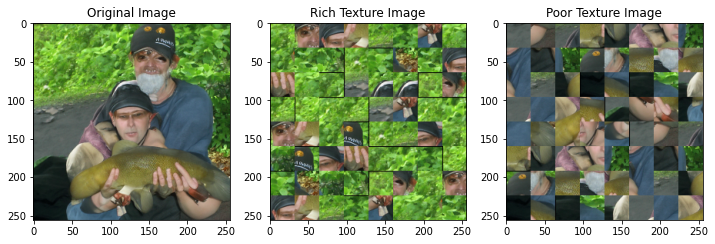

In [163]:
from PIL import Image
img_path = "/mnt/c/Users/kosta/Downloads/Screenshot 2024-04-28 002208.png"
img = Image.open(img_path).convert('RGB')  # Convert to grayscale

rich_texture_img, poor_texture_img = smash_n_reconstruct( img)

plt.figure(figsize=(12, 6))
plt.subplot(1, 3, 1)
plt.imshow(img, cmap='gray')
plt.title('Original Image')
plt.subplot(1, 3, 2)
plt.imshow(rich_texture_img, cmap='gray')
plt.title('Rich Texture Image')
plt.subplot(1, 3, 3)
plt.imshow(poor_texture_img, cmap='gray')
plt.title('Poor Texture Image')
plt.show()